# UM-Bridge with QMCPy

Computing the mean of the [UM-Bridge Cantilever Beam Function](https://um-bridge-benchmarks.readthedocs.io/en/docs/forward-benchmarks/muq-beam-propagation.html) using QMCPy. 

In [1]:
import umbridge
from qmcpy import *

In [2]:
import os
from matplotlib import pyplot
pyplot.style.use('../qmcpy.mplstyle')

Start a docker image. See the [UM-Bridge Documentation](https://um-bridge-benchmarks.readthedocs.io/en/docs/index.html) for image options. 

In [3]:
!docker run --name muqbp -d -it -p 4243:4243 linusseelinger/benchmark-muq-beam-propagation:latest

bc128ea2e93567382c3ff93e16b1c9022ec9a29c52b52630d7f6a9ca3db3ef78


Initialize a QMCPy distribution and UM-Bridge model.

In [4]:
dnb2 = DigitalNetB2(dimension=3,seed=7)
distribution = Uniform(dnb2,lower_bound=1,upper_bound=1.05)
model = umbridge.HTTPModel('http://localhost:4243','forward')
umbridge_config = {"d": dnb2.d}

Wrap the UM-Bridge mode into a QMCPy compatible Integrand and run a QMC stopping criterion algorithm.  

In [5]:
um_bridge_integrand = UMBridgeWrapper(distribution,model,umbridge_config,parallel=False)
solution,data = CubQMCNetG(um_bridge_integrand,abs_tol=2.5e-2).integrate()
print(data)

LDTransformData (AccumulateData Object)
    solution        [  0.      3.855  14.69  ... 898.921 935.383 971.884]
    comb_bound_low  [  0.      3.854  14.688 ... 898.901 935.363 971.863]
    comb_bound_high [  0.      3.855  14.691 ... 898.941 935.404 971.906]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(11)
    n               [1024. 1024. 1024. ... 2048. 2048. 2048.]
    time_integrate  8.723
CubQMCNetG (StoppingCriterion Object)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.050
DigitalNetB2 (DiscreteDistribution Object)
    d               3
    dvec            [0 1 2]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()


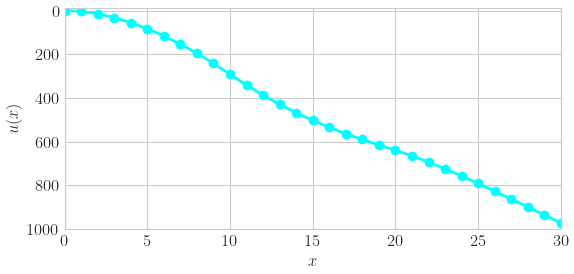

In [6]:
fig,ax = pyplot.subplots(figsize=(6,3))
ax.plot(solution,'-o')
ax.set_xlim([0,len(solution)-1]); ax.set_xlabel(r'$x$')
ax.set_ylim([1000,-10]);  ax.set_ylabel(r'$u(x)$');

QMCPy can automatically multi-threaded requests to the model by setting `parallel=p` where `p` is the number of processors used by [multiprocessing.pool.ThreadPool](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.ThreadPool). Setting `parallel=True` is equivalent to setting `paralle=os.cpu_count()`.

In [7]:
print('Available CPUs: %d'%os.cpu_count())
ps = list(range(1,os.cpu_count()+1))
print('ps =',ps)
times = [0]*len(ps)
print(' p =  ',end='',flush=True)  
for i in range(len(ps)):
    p = ps[i]
    print('%d, '%p,end='',flush=True)
    um_bridge_integrand = UMBridgeWrapper(distribution,model,umbridge_config,parallel=p)
    solution,data = CubQMCNetG(um_bridge_integrand,abs_tol=2.5e-2).integrate()
    times[i] = data.time_integrate

Available CPUs: 12
ps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
 p =  1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 

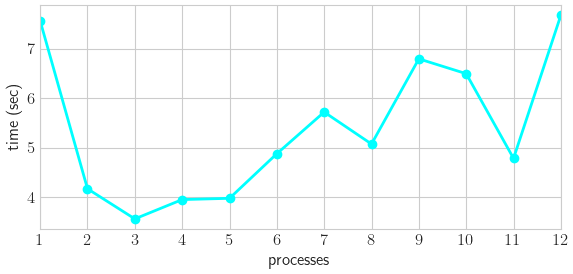

In [8]:
fig,ax = pyplot.subplots(figsize=(6,3))
ax.plot(ps,times,'-o')
ax.set_xlabel('processes'); ax.set_xlim([ps[0],ps[-1]]); ax.set_xticks(ps); #ax.set_xscale('log',base=2)
ax.set_ylabel('time (sec)'); #ax.set_yscale('log',base=10)

Remove the created docker image

In [9]:
!docker rm -f muqbp

IOStream.flush timed out
muqbp
